This notebook is for creating graphs of the benchmark case study, specifically using datasets where all the data is available.

Currently this notebook resides in the `notebooks` folder, but in order for it to run, it must be moved out to the main folder. 

# Set up 

In [1]:
import tellurium as te
import pandas as pd
import numpy as np
np.random.seed(SEED)

import matplotlib.pyplot as plt
import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np

import cobra
import os

from scipy import stats
import scipy as sp

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# import sys
# sys.path.insert(0, 'C:/Users/user/Documents/research/BMCA-pipeline')
os.chdir('../..')
from src import BMCA, util
import emll

# Perturbing boundary metabolites, specifically EtOH

First, we use data where [EtOH] is perturbed

In [3]:
# elasticity_to_CCC(BIOMD64, r.getScaledElasticityMatrix())
Teusink_ant ='data/interim/Antimony/BIOMD0000000064_e.ant' 
data_file = 'data/interim/generated_data/EtOHcompilation.csv'
data = pd.read_csv(data_file)

r = te.loada(Teusink_ant)

r.conservedMoietyAnalysis = True
r.steadyState()
scaledE = r.getScaledElasticityMatrix()

In [4]:
BIOMD64 = BMCA.BMCA(Teusink_ant, data_file)

Model does not contain SBML fbc package information.


Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-19


Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPGI>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPGI>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLYCO>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLYCO>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vTreha>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vTreha>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPFK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPFK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vALD>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vALD>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGAPDH>'
Missing upper flux bound set to '1

## Running ADVI

In [5]:
with pm.Model() as pymc_model:
    
    # Initialize elasticities
    Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BIOMD64.Ex.to_numpy(), name='Ex'))
    Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BIOMD64.Ey.to_numpy(), name='Ey'))

    trace_prior = pm.sample_prior_predictive(samples=1000)

Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]


In [6]:
with pymc_model:
    
    # e_obs = pm.Normal('e_obs', mu=BIOMD64.en.T, sigma=0.1)
    chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BIOMD64.xn.T) 
    y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BIOMD64.yn.T) 

    likelihood = pm.Deterministic('vn', (np.ones((17,30)) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
    v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BIOMD64.vn.squeeze().T)

pymc_model.free_RVs

[Ex_kinetic_entries ~ SkewNormal(0, 1, 5),
 Ex_capacity_entries ~ Laplace(0, 0.01),
 Ey_kinetic_entries ~ SkewNormal(0, 1, 5),
 Ey_capacity_entries ~ Laplace(0, 0.01)]

In [7]:
N_ITERATIONS = 50000
with pymc_model:
    advi = pm.ADVI()
    tracker = pm.callbacks.Tracker(
        mean = advi.approx.mean.eval,
        std = advi.approx.std.eval
    )
    approx = advi.fit(
        n=       N_ITERATIONS, 
        callbacks = [tracker],
        obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
        total_grad_norm_constraint=0.7,
        obj_n_mc=1)
    
    trace_vi = approx.sample(draws=1000, random_seed=1) 
    ppc_vi = pm.sample_posterior_predictive(trace_vi, random_seed=1)
    

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,681.1
Sampling: [chi_obs, v_hat_obs, y_obs]


### Plotting ADVI results

In [8]:
Ex_trace = (trace_vi['posterior']['Ex']).to_numpy().squeeze().transpose(1, 2, 0)

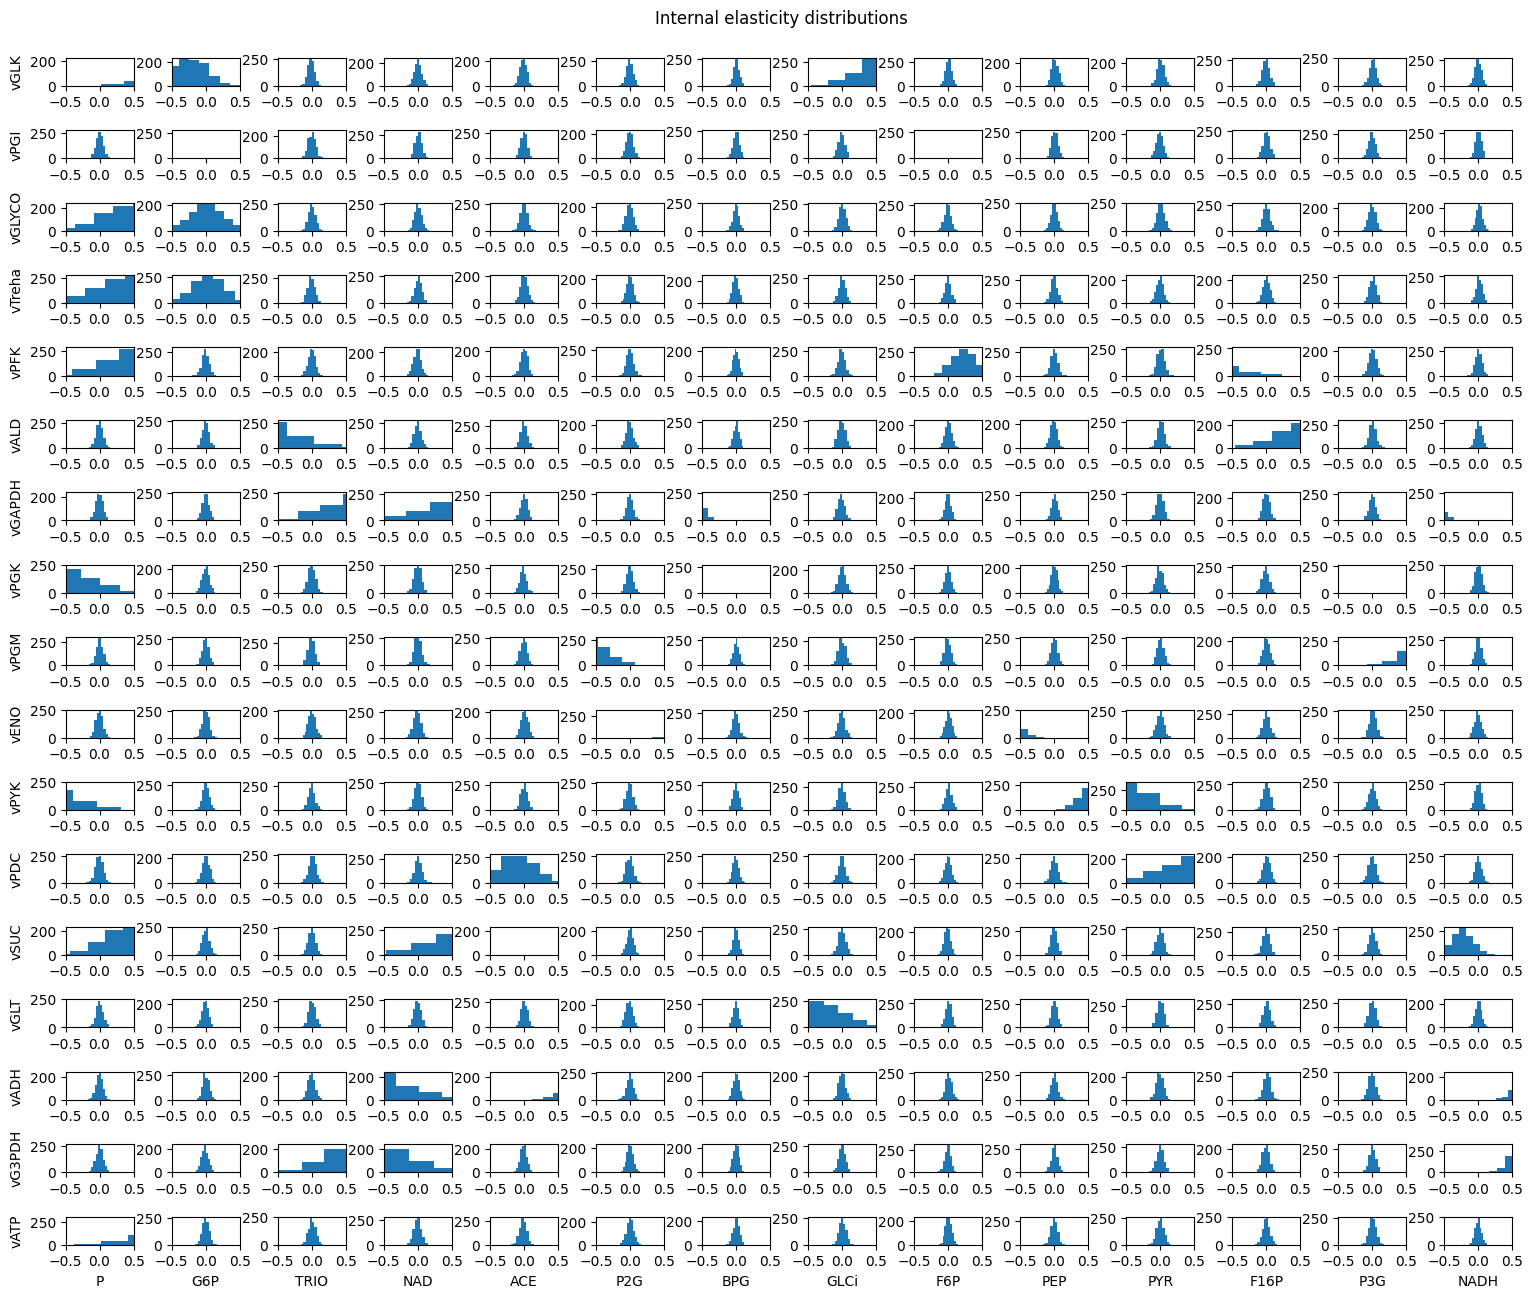

In [9]:
# create a subplot that is (17,14)
fig, axs = plt.subplots(17,14, figsize=(15, 13)) 

fig.suptitle('Internal elasticity distributions\n')
fig.tight_layout()

for i in range(17):
  for ii in range(14):
    axs[i,ii].hist(Ex_trace[i,ii,:])
    axs[i,ii].set_xlim([-0.5,0.5])

    if ii == 0:
      axs[i,ii].set_ylabel(r.getReactionIds()[i])
    if i == 16: 
      axs[i,ii].set_xlabel(r.getFloatingSpeciesIds()[ii])

all distributions are unimodal so we estimate that the peak of the distribution is the median

In [10]:
Ex_peaks=[]

for i in range(Ex_trace.shape[0]):
    for ii in range(Ex_trace.shape[1]):
        Ex_peaks.append(np.percentile(Ex_trace[i,ii,:],50))


In [11]:
# these are the elasticity posteriors from Bayesian inference
x = np.array(Ex_peaks)
# 0 out all magnitudes that have less than a magnitude of 0.01
x[abs(x) < 0.01] = 0

x = x.reshape((17,14))
Ex = pd.DataFrame(x, index=r.getReactionIds(), columns=r.getFloatingSpeciesIds())
Ex

,P,G6P,TRIO,NAD,ACE,P2G,BPG,GLCi,F6P,PEP,PYR,F16P,P3G,NADH
vGLK,1.593898,-0.230010,-0.011974,0.000000,-0.010910,0.000000,0.000000,0.559251,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
vPGI,0.000000,1.891299,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.177590,0.000000,0.000000,0.000000,0.000000,0.000000
vGLYCO,0.541057,0.015154,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010016
vTreha,0.415592,0.048586,0.000000,0.010179,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011191
vPFK,0.625643,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.234529,0.000000,0.000000,-1.319057,0.000000,0.000000
vALD,0.000000,0.000000,-0.860707,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.682044,0.000000,0.000000
vGAPDH,0.000000,0.000000,0.808778,0.778693,0.000000,0.000000,-0.631922,-0.011154,0.000000,0.000000,0.000000,0.000000,0.000000,-0.726226
vPGK,-0.632677,0.000000,0.000000,0.000000,0.000000,0.000000,0.958344,0.000000,0.000000,0.000000,-0.011242,0.000000,-1.884764,0.000000
vPGM,0.000000,0.000000,0.000000,0.000000,0.000000,-0.611953,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.876603,0.000000
vENO,0.000000,0.000000,0.000000,0.000000,0.000000,1.345475,0.000000,0.000000,0.000000,-0.740767,0.000000,0.000000,0.000000,0.000000


In [12]:
Ey_trace = (trace_vi['posterior']['Ey']).to_numpy().squeeze().transpose(1, 2, 0)
Ey_trace.shape

(17, 5, 1000)

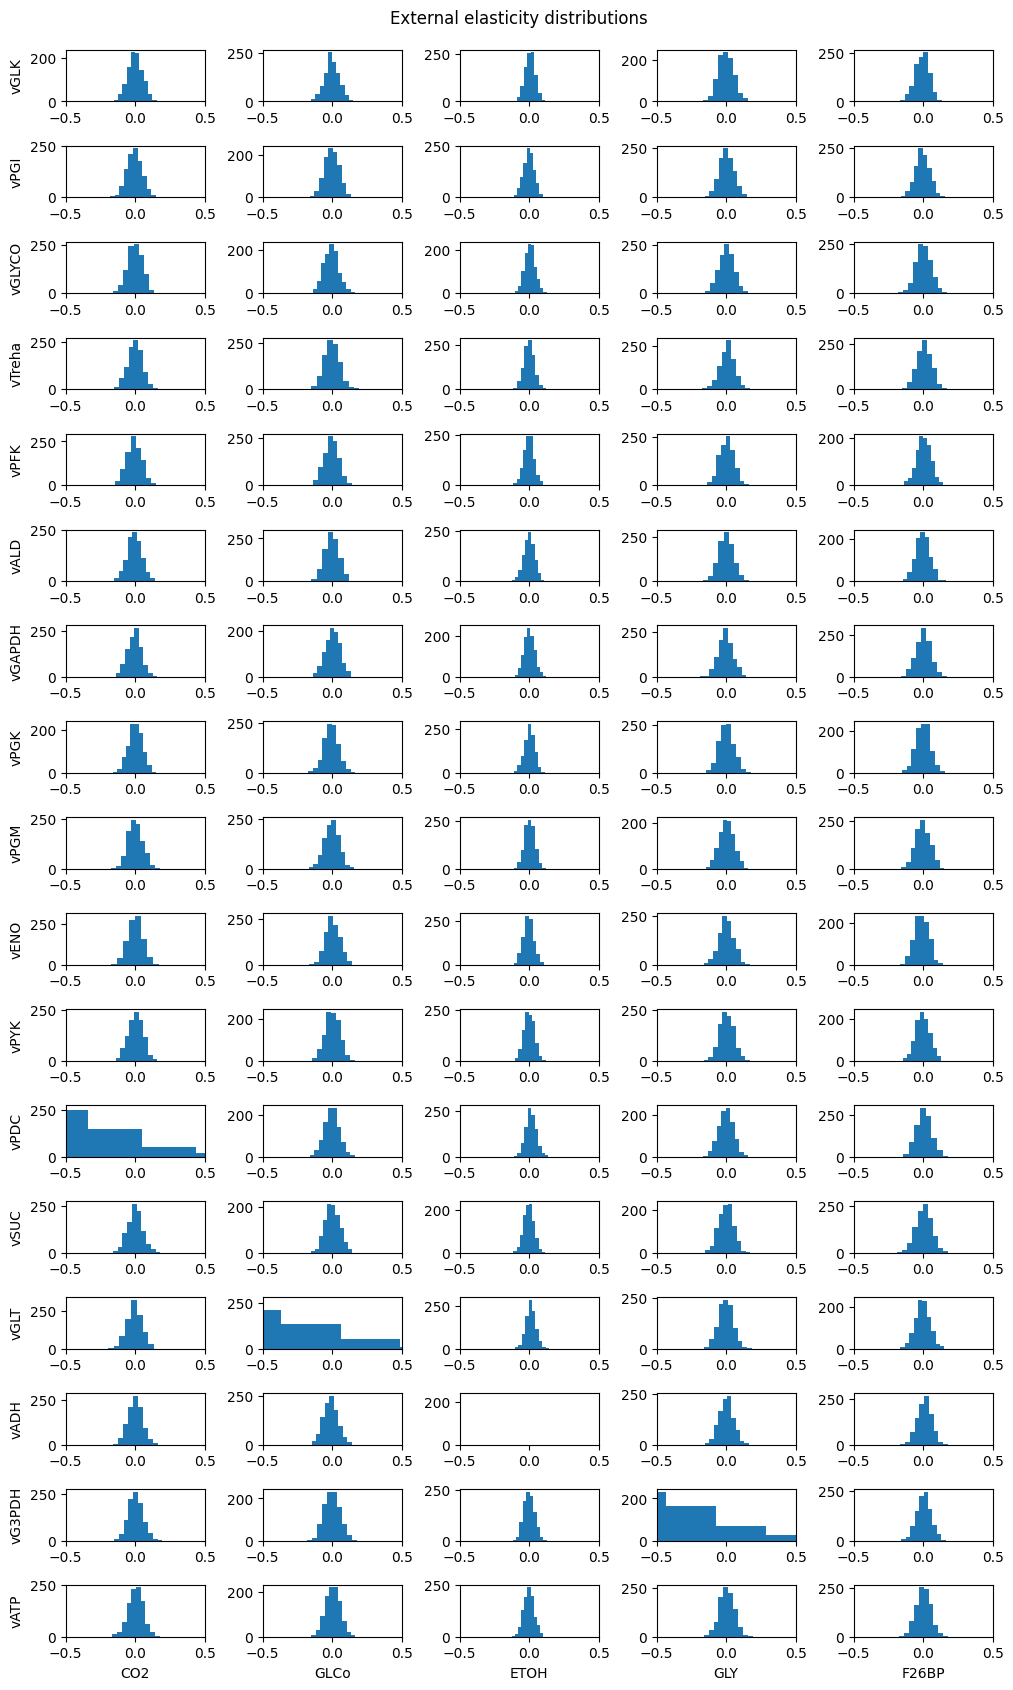

In [13]:
# create a subplot that is (17,14)
fig, axs = plt.subplots(17,5, figsize=(10, 17)) 

fig.suptitle('External elasticity distributions\n')
fig.tight_layout()

for i in range(17):
  for ii in range(5):
    axs[i,ii].hist(Ey_trace[i,ii,:])
    axs[i,ii].set_xlim([-0.5,0.5])

    if ii == 0:
      axs[i,ii].set_ylabel(r.getReactionIds()[i])
    if i == 16: 
      axs[i,ii].set_xlabel(r.getBoundarySpeciesIds()[ii])

In [14]:
Ey_peaks=[]

for i in range(Ey_trace.shape[0]):
    for ii in range(Ey_trace.shape[1]):
        Ey_peaks.append(np.percentile(Ey_trace[i,ii,:],50))


In [15]:
# elasticities from Bayesian inf posteriors

y = np.array(Ey_peaks)
# 0 out all magnitudes that have less than a magnitude of 0.01
y[abs(y) < 0.01] = 0

y = y.reshape((17,5))
Ey = pd.DataFrame(y, index=r.getReactionIds(), columns=r.getBoundarySpeciesIds())
Ey

,CO2,GLCo,ETOH,GLY,F26BP
vGLK,0.000000,0.000000,0.000000,0.000000,0.000000
vPGI,0.000000,0.000000,0.000000,0.000000,0.000000
vGLYCO,0.000000,0.000000,0.000000,0.000000,0.000000
vTreha,0.000000,0.000000,0.000000,0.010448,0.000000
vPFK,0.000000,0.000000,0.000000,0.000000,0.000000
vALD,0.000000,0.000000,0.000000,0.000000,0.000000
vGAPDH,0.000000,0.000000,0.000000,0.000000,0.000000
vPGK,0.000000,0.000000,0.000000,0.000000,0.000000
vPGM,0.000000,0.000000,0.000000,0.000000,0.000000
vENO,0.000000,0.000000,0.000000,0.000000,-0.013113


In [16]:
a = data['ETOH']/50
a.drop(a.index[0],inplace=True)

In [17]:
# get the real values
real_values = data[[i for i in data.columns if 'v_' in i]]
rel_real_values = real_values.div(real_values.iloc[0])
rel_real_values.drop(rel_real_values.index[0], inplace=True)
rel_real_values.columns = r.getReactionIds()
rel_real_values = rel_real_values.transpose()
rel_real_values.columns = a.round(2).values
rel_real_values


,0.28,0.48,0.63,0.73,0.81,0.86,0.90,0.93,0.95,0.96,0.97,0.98,0.99,0.99,1.00,1.01,1.01,1.02,1.03,1.04,1.05,1.07,1.10,1.14,1.19,1.27,1.37,1.52,1.72,2.00
vGLK,1.013158,1.009094,1.006402,1.004547,1.003245,1.002322,1.001665,1.001195,1.000858,1.000617,1.000444,1.000319,1.000230,1.000165,1.0,0.999835,0.999771,0.999682,0.999558,0.999387,0.999149,0.998819,0.998363,0.997732,0.996860,0.995658,0.994002,0.991724,0.988587,0.984251
vPGI,1.014996,1.010364,1.007296,1.005182,1.003698,1.002646,1.001897,1.001362,1.000978,1.000703,1.000506,1.000364,1.000262,1.000188,1.0,0.999812,0.999739,0.999638,0.999497,0.999301,0.999030,0.998655,0.998135,0.997415,0.996422,0.995052,0.993165,0.990568,0.986993,0.982052
vGLYCO,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
vTreha,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
vPFK,1.014996,1.010364,1.007296,1.005182,1.003698,1.002646,1.001897,1.001362,1.000978,1.000703,1.000506,1.000364,1.000262,1.000188,1.0,0.999812,0.999739,0.999638,0.999497,0.999301,0.999030,0.998655,0.998135,0.997415,0.996422,0.995052,0.993165,0.990568,0.986993,0.982052
vALD,1.014996,1.010364,1.007296,1.005182,1.003698,1.002646,1.001897,1.001362,1.000978,1.000703,1.000506,1.000364,1.000262,1.000188,1.0,0.999812,0.999739,0.999638,0.999497,0.999301,0.999030,0.998655,0.998135,0.997415,0.996422,0.995052,0.993165,0.990568,0.986993,0.982052
vGAPDH,1.060226,1.039023,1.026441,1.018319,1.012855,1.009095,1.006468,1.004616,1.003303,1.002367,1.001698,1.001220,1.000877,1.000630,1.0,0.999373,0.999130,0.998793,0.998327,0.997682,0.996791,0.995565,0.993883,0.991584,0.988462,0.984252,0.978626,0.971185,0.961460,0.948890
vPGK,1.060226,1.039023,1.026441,1.018319,1.012855,1.009095,1.006468,1.004616,1.003303,1.002367,1.001698,1.001220,1.000877,1.000630,1.0,0.999373,0.999130,0.998793,0.998327,0.997682,0.996791,0.995565,0.993883,0.991584,0.988462,0.984252,0.978626,0.971185,0.961460,0.948890
vPGM,1.060226,1.039023,1.026441,1.018319,1.012855,1.009095,1.006468,1.004616,1.003303,1.002367,1.001698,1.001220,1.000877,1.000630,1.0,0.999373,0.999130,0.998793,0.998327,0.997682,0.996791,0.995565,0.993883,0.991584,0.988462,0.984252,0.978626,0.971185,0.961460,0.948890
vENO,1.060226,1.039023,1.026441,1.018319,1.012855,1.009095,1.006468,1.004616,1.003303,1.002367,1.001698,1.001220,1.000877,1.000630,1.0,0.999373,0.999130,0.998793,0.998327,0.997682,0.996791,0.995565,0.993883,0.991584,0.988462,0.984252,0.978626,0.971185,0.961460,0.948890


In [18]:
# c_df is the flux calculated using the Bayesian inference PRIORS for elasticity
c = np.diag(BIOMD64.v_star)@(np.ones(BIOMD64.N.shape[1]).reshape((-1,1)) + BIOMD64.Ex@(BIOMD64.xn).T + BIOMD64.Ey@(BIOMD64.yn).T)
c_df = pd.DataFrame(c) #, index=r.getReactionIds(), columns=a.round(2).values) 
c_df.index = r.getReactionIds()
c_df.columns = a.round(2).values
c_df = c_df.divide(c_df[1.00], axis=0)
c_df

,0.28,0.48,0.63,0.73,0.81,0.86,0.90,0.93,0.95,0.96,0.97,0.98,0.99,0.99,1.00,1.01,1.01,1.02,1.03,1.04,1.05,1.07,1.10,1.14,1.19,1.27,1.37,1.52,1.72,2.00
vGLK,0.527154,0.712401,0.811909,0.872518,0.911809,0.938208,0.956345,0.968987,0.977883,0.984186,0.988671,0.991874,0.994165,0.995808,1.0,1.004156,1.005765,1.007992,1.011070,1.015315,1.021152,1.029148,1.040046,1.054798,1.074593,1.100856,1.135227,1.179500,1.235558,1.305404
vPGI,0.822680,0.884880,0.922265,0.946359,0.962485,0.973531,0.981214,0.986612,0.990432,0.993149,0.995087,0.996473,0.997466,0.998179,1.0,1.001809,1.002510,1.003482,1.004826,1.006682,1.009240,1.012755,1.017564,1.024106,1.032938,1.044741,1.060312,1.080516,1.106210,1.138118
vGLYCO,1.495558,1.301111,1.196813,1.133338,1.092214,1.064595,1.045627,1.032411,1.023111,1.016524,1.011837,1.008491,1.006096,1.004380,1.0,0.995658,0.993977,0.991651,0.988436,0.984004,0.977908,0.969560,0.958185,0.942792,0.922150,0.894784,0.859012,0.813024,0.754969,0.682987
vTreha,1.495558,1.301111,1.196813,1.133338,1.092214,1.064595,1.045627,1.032411,1.023111,1.016524,1.011837,1.008491,1.006096,1.004380,1.0,0.995658,0.993977,0.991651,0.988436,0.984004,0.977908,0.969560,0.958185,0.942792,0.922150,0.894784,0.859012,0.813024,0.754969,0.682987
vPFK,1.521604,1.331045,1.220366,1.150743,1.104846,1.073706,1.052185,1.037128,1.026503,1.018964,1.013592,1.009753,1.007004,1.005033,1.0,0.995006,0.993071,0.990392,0.986688,0.981577,0.974541,0.964890,0.951715,0.933843,0.909804,0.877818,0.835839,0.781664,0.713097,0.628140
vALD,1.064559,1.036710,1.023502,1.015788,1.010875,1.007602,1.005364,1.003808,1.002714,1.001940,1.001389,1.000997,1.000715,1.000514,1.0,0.999491,0.999293,0.999021,0.998643,0.998124,0.997409,0.996430,0.995096,0.993291,0.990868,0.987650,0.983427,0.977958,0.970964,0.962099
vGAPDH,0.947589,0.985627,0.996173,0.999595,1.000673,1.000910,1.000853,1.000711,1.000559,1.000424,1.000316,1.000234,1.000171,1.000125,1.0,0.999867,0.999815,0.999736,0.999626,0.999468,0.999233,0.998887,0.998361,0.997557,0.996319,0.994395,0.991418,0.986875,0.980107,0.970391
vPGK,1.354944,1.203564,1.128954,1.085674,1.058484,1.040606,1.028504,1.020157,1.014329,1.010224,1.007313,1.005238,1.003759,1.002699,1.0,0.997333,0.996301,0.994879,0.992915,0.990212,0.986513,0.981467,0.974645,0.965503,0.953403,0.937661,0.917609,0.892732,0.862860,0.828361
vPGM,0.957849,0.976317,0.985127,0.990161,0.993299,0.995354,0.996741,0.997696,0.998363,0.998832,0.999165,0.999402,0.999571,0.999692,1.0,1.000304,1.000422,1.000584,1.000809,1.001117,1.001539,1.002114,1.002891,1.003933,1.005311,1.007106,1.009395,1.012245,1.015694,1.019742
vENO,0.807727,0.887966,0.928470,0.952253,0.967305,0.977253,0.984009,0.988679,0.991946,0.994252,0.995887,0.997052,0.997885,0.998481,1.0,1.001502,1.002083,1.002886,1.003993,1.005518,1.007607,1.010459,1.014323,1.019513,1.026401,1.035404,1.046942,1.061376,1.078921,1.099550


Text(0.04, 0.5, 'relative fluxes predicted with Bayesian inference')

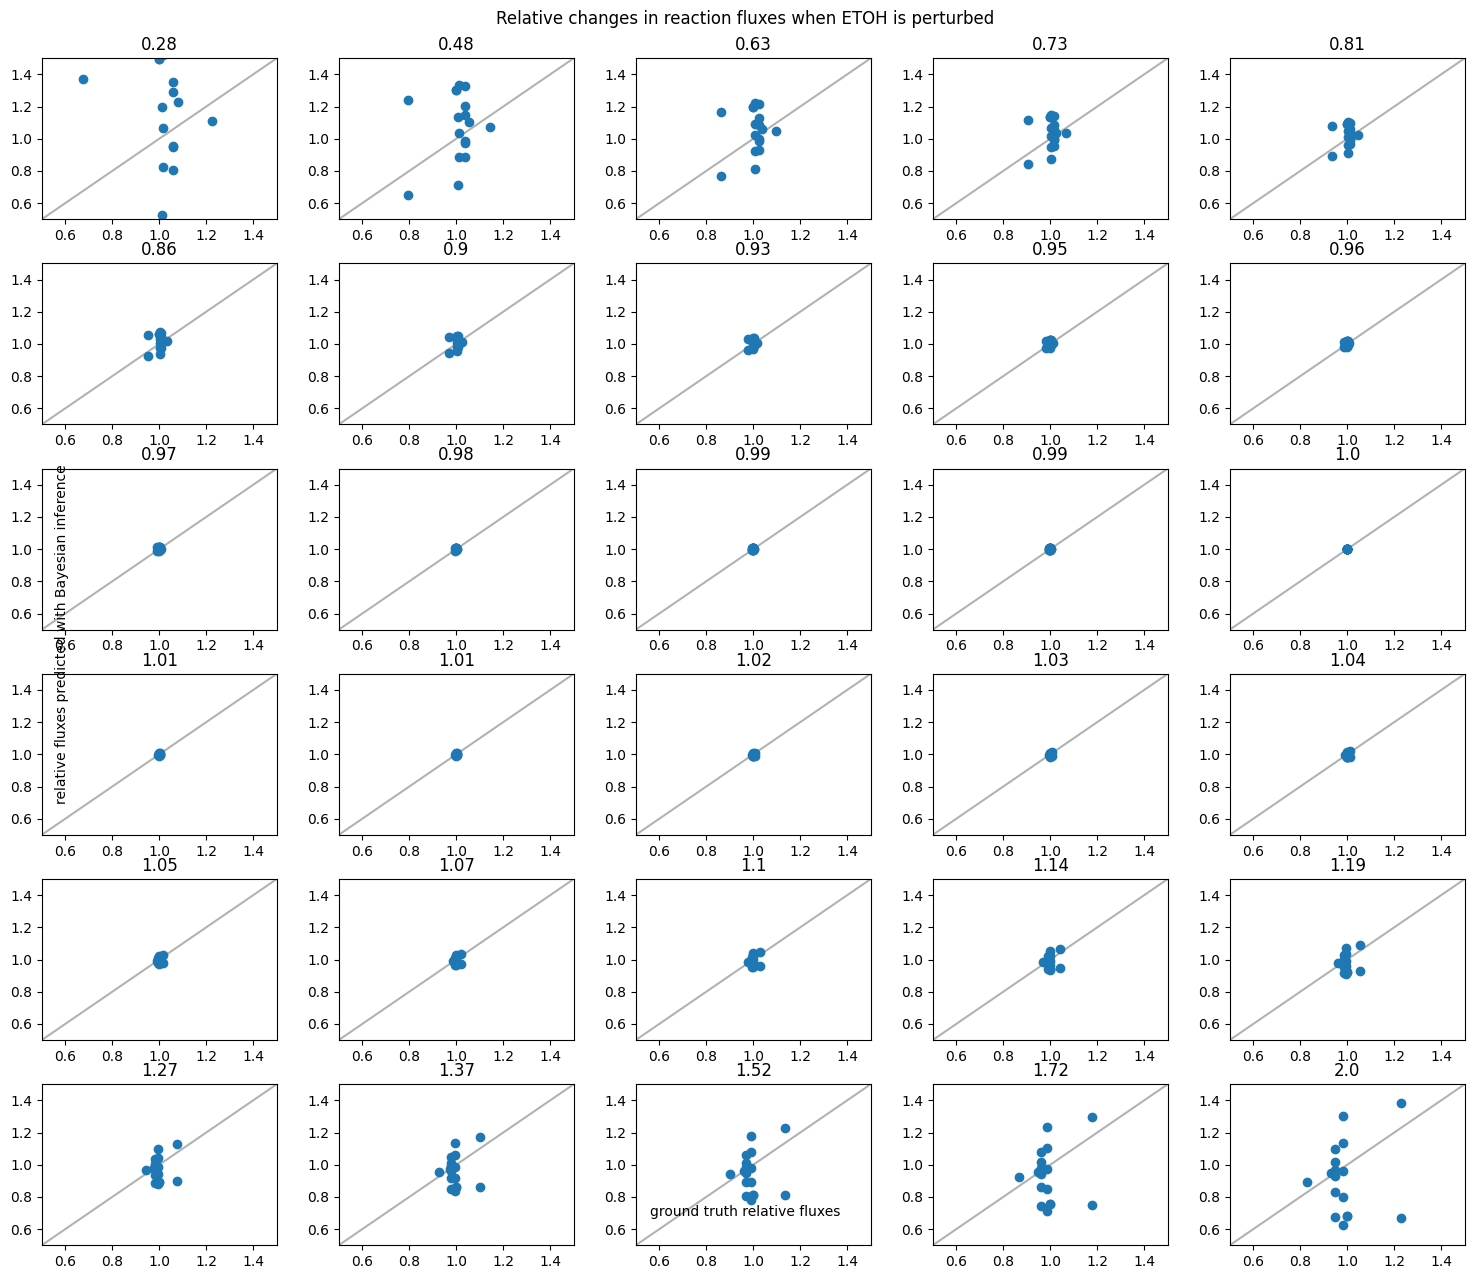

In [19]:
fig, axs = plt.subplots(6,5, figsize=(15, 13)) 
idx_starter = -1

fig.suptitle('Relative changes in reaction fluxes when ETOH is perturbed\n')
fig.tight_layout()

lims = [0.5,1.5]

for i,col in enumerate(c_df.columns): 
    if i%5==0:
      idx_starter += 1
    axs[idx_starter, i%5].plot(lims, lims, 'k-', alpha=0.3, zorder=0)
    axs[idx_starter, i%5].scatter(rel_real_values[col], c_df[col])
    axs[idx_starter, i%5].set_xlim(lims)
    axs[idx_starter, i%5].set_ylim(lims)
    #axs[idx_starter, i%5].set_xlabel('ground truth relative fluxes\n\n')
    #axs[idx_starter, i%5].set_ylabel('relative fluxes predicted with Bayesian inference')
    axs[idx_starter, i%5].set_title(col)

fig.text(0.5, 0.04, 'ground truth relative fluxes\n', ha='center')
fig.text(0.04, 0.5, 'relative fluxes predicted with Bayesian inference', va='center', rotation='vertical')


#plt.legend(["fully parameterized", "Visser priors", "real values"])
#plt.show()

In [20]:
# d_df is the flux calculated using the Bayesian inference POSTERIORS for elasticity
d = np.diag(BIOMD64.v_star)@(np.ones(BIOMD64.N.shape[1]).reshape((-1,1)) + x@(BIOMD64.xn).T + y@(BIOMD64.yn).T)
d_df = pd.DataFrame(d) #, index=r.getReactionIds(), columns=a.round(2).values) 
d_df.index = r.getReactionIds()
d_df.columns = a.round(2).values
d_df = d_df.divide(d_df[1.00], axis=0)
d_df

,0.28,0.48,0.63,0.73,0.81,0.86,0.90,0.93,0.95,0.96,0.97,0.98,0.99,0.99,1.00,1.01,1.01,1.02,1.03,1.04,1.05,1.07,1.10,1.14,1.19,1.27,1.37,1.52,1.72,2.00
vGLK,0.979884,0.991984,0.996431,0.998317,0.999178,0.999588,0.999790,0.999891,0.999943,0.999969,0.999983,0.999991,0.999995,0.999997,1.0,0.999999,0.999998,0.999996,0.999990,0.999980,0.999959,0.999918,0.999841,0.999697,0.999428,0.998940,0.998074,0.996578,0.994082,0.990077
vPGI,1.066027,1.026963,1.012916,1.006817,1.003856,1.002301,1.001433,1.000923,1.000611,1.000413,1.000284,1.000197,1.000139,1.000098,1.0,0.999911,0.999879,0.999836,0.999781,0.999713,0.999632,0.999547,0.999479,0.999471,0.999613,1.000061,1.001072,1.003034,1.006456,1.011895
vGLYCO,1.059221,1.039275,1.026970,1.018845,1.013300,1.009445,1.006736,1.004816,1.003451,1.002475,1.001777,1.001277,1.000918,1.000660,1.0,0.999343,0.999087,0.998733,0.998243,0.997564,0.996625,0.995330,0.993548,0.991103,0.987765,0.983231,0.977114,0.968926,0.958057,0.943739
vTreha,1.057621,1.037318,1.025299,1.017540,1.012317,1.008718,1.006202,1.004428,1.003169,1.002271,1.001630,1.001171,1.000841,1.000605,1.0,0.999398,0.999165,0.998841,0.998393,0.997773,0.996918,0.995739,0.994121,0.991908,0.988899,0.984834,0.979387,0.972158,0.962659,0.950289
vPFK,1.001477,1.013958,1.012654,1.009854,1.007346,1.005384,1.003915,1.002835,1.002048,1.001478,1.001065,1.000768,1.000553,1.000398,1.0,0.999601,0.999445,0.999228,0.998927,0.998507,0.997923,0.997108,0.995974,0.994394,0.992197,0.989154,0.984968,0.979272,0.971656,0.961722
vALD,1.028539,1.016377,1.010548,1.007115,1.004915,1.003442,1.002432,1.001728,1.001233,1.000882,1.000632,1.000453,1.000325,1.000234,1.0,0.999768,0.999678,0.999554,0.999382,0.999145,0.998819,0.998372,0.997762,0.996934,0.995819,0.994333,0.992371,0.989811,0.986503,0.982256
vGAPDH,1.046550,1.038899,1.028963,1.021042,1.015178,1.010921,1.007854,1.005649,1.004062,1.002921,1.002101,1.001512,1.001087,1.000782,1.0,0.999218,0.998915,0.998491,0.997904,0.997091,0.995961,0.994396,0.992229,0.989233,0.985108,0.979448,0.971735,0.961335,0.947508,0.929485
vPGK,1.073287,1.048413,1.031948,1.021560,1.014815,1.010318,1.007252,1.005130,1.003648,1.002604,1.001863,1.001334,1.000958,1.000688,1.0,0.999321,0.999057,0.998697,0.998197,0.997509,0.996569,0.995286,0.993557,0.991248,0.988208,0.984298,0.979418,0.973578,0.967026,0.960403
vPGM,1.060206,1.033912,1.021555,1.014411,1.009894,1.006901,1.004861,1.003447,1.002455,1.001754,1.001256,1.000900,1.000646,1.000464,1.0,0.999540,0.999362,0.999116,0.998777,0.998309,0.997666,0.996786,0.995590,0.993975,0.991815,0.988959,0.985237,0.980461,0.974432,0.966937
vENO,1.079565,1.041932,1.026056,1.017264,1.011809,1.008223,1.005789,1.004103,1.002922,1.002088,1.001495,1.001072,1.000769,1.000553,1.0,0.999453,0.999241,0.998948,0.998543,0.997986,0.997219,0.996170,0.994742,0.992809,0.990216,0.986766,0.982222,0.976293,0.968606,0.958653


Text(0.04, 0.5, 'relative fluxes predicted with Bayesian inference')

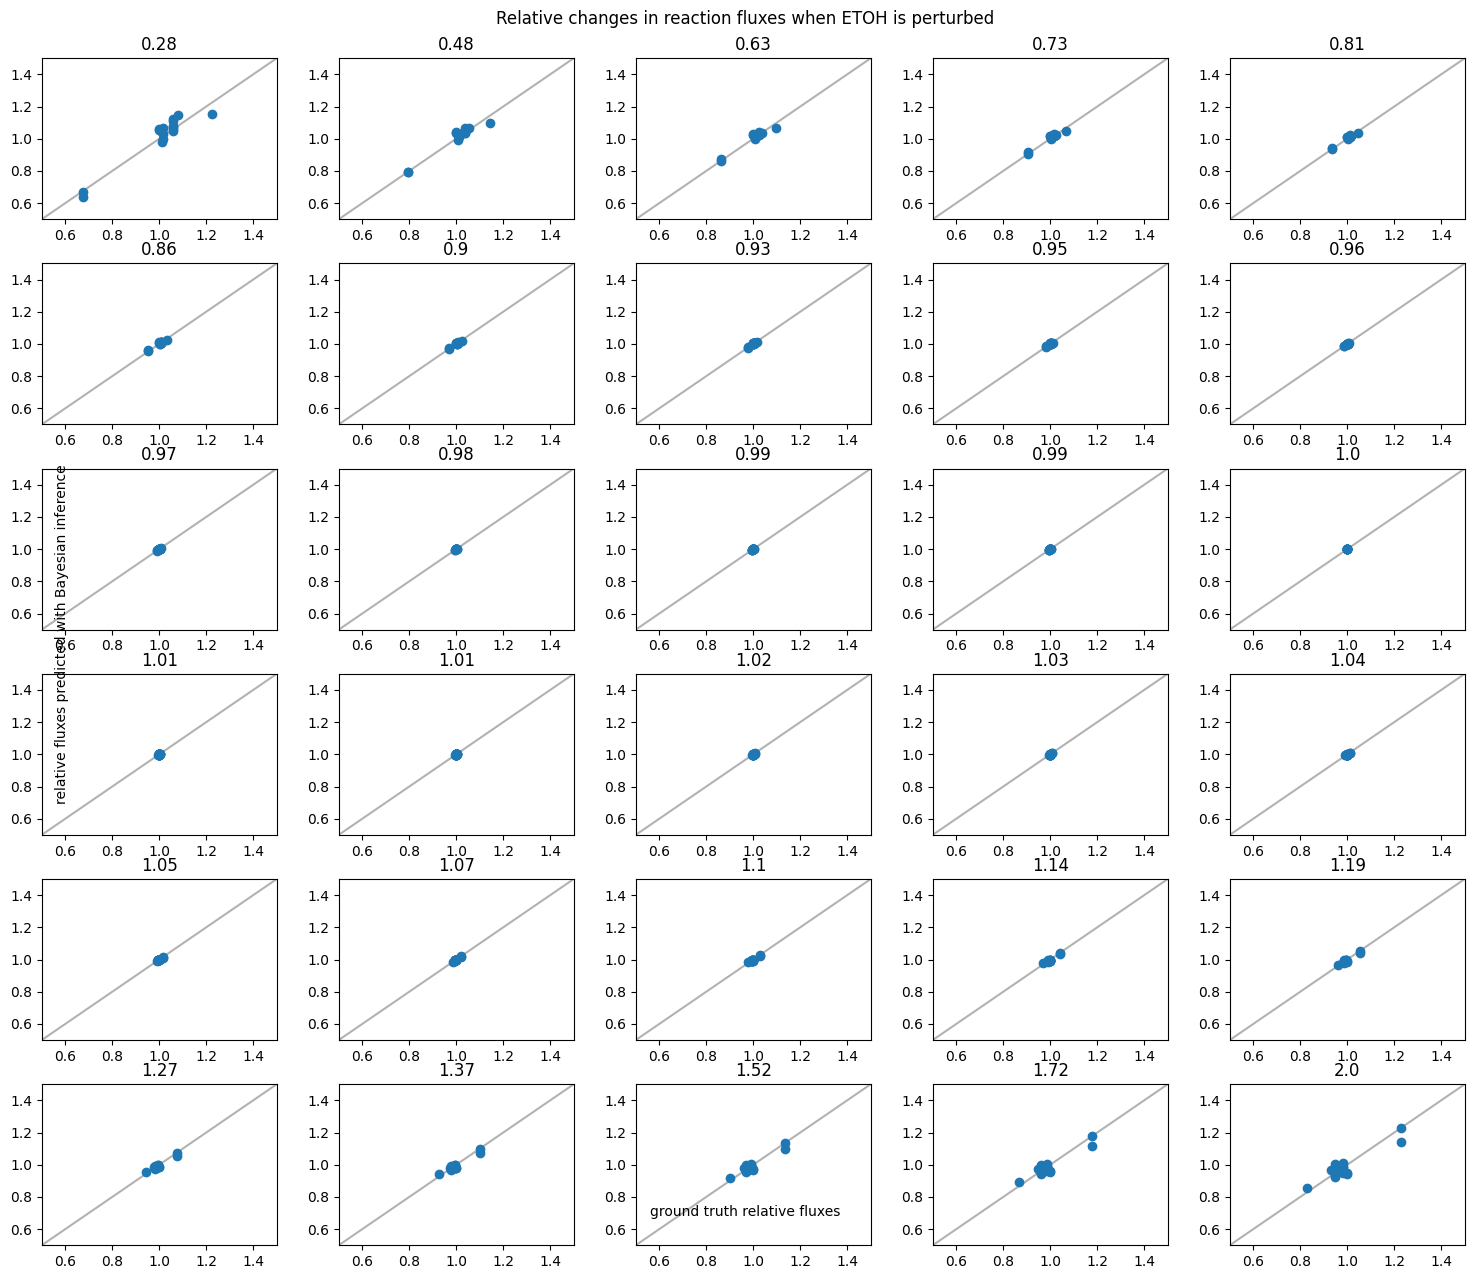

In [21]:
fig, axs = plt.subplots(6,5, figsize=(15, 13)) 
idx_starter = -1

fig.suptitle('Relative changes in reaction fluxes when ETOH is perturbed\n')
fig.tight_layout()

lims = [0.5,1.5]

for i,col in enumerate(d_df.columns): 
    if i%5==0:
      idx_starter += 1
    axs[idx_starter, i%5].plot(lims, lims, 'k-', alpha=0.3, zorder=0)
    axs[idx_starter, i%5].scatter(rel_real_values[col], d_df[col])
    axs[idx_starter, i%5].set_xlim(lims)
    axs[idx_starter, i%5].set_ylim(lims)
    #axs[idx_starter, i%5].set_xlabel('ground truth relative fluxes\n\n')
    #axs[idx_starter, i%5].set_ylabel('relative fluxes predicted with Bayesian inference')
    axs[idx_starter, i%5].set_title(col)

fig.text(0.5, 0.04, 'ground truth relative fluxes\n', ha='center')
fig.text(0.04, 0.5, 'relative fluxes predicted with Bayesian inference', va='center', rotation='vertical')


#plt.legend(["fully parameterized", "Visser priors", "real values"])
#plt.show()

Text(-9, 4, 'r = 0.518')

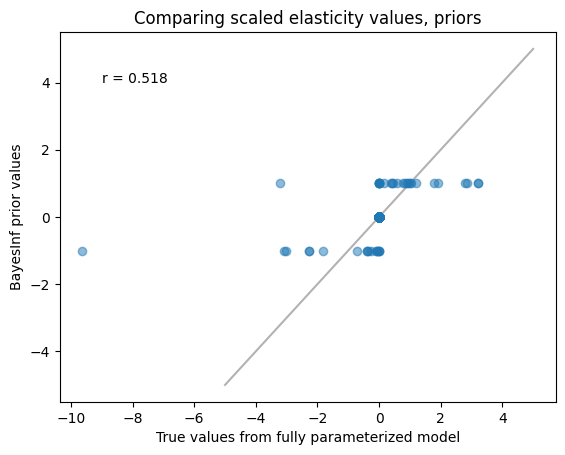

In [22]:
x # the posterior (bayes inf) elasticity values
BIOMD64.Ex # the prior elasticity values
Ex_values = r.getScaledElasticityMatrix()


fig = plt.figure()

plt.scatter(Ex_values, BIOMD64.Ex, alpha=0.5)
plt.plot([-5,5], [-5,5], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled elasticity values, priors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf prior values')

plt.text(-9,4,'r = ' + str((stats.pearsonr(Ex_values.flatten(), BIOMD64.Ex.to_numpy().flatten())[0]).round(3)))


Text(-9, 4, 'r = 0.54')

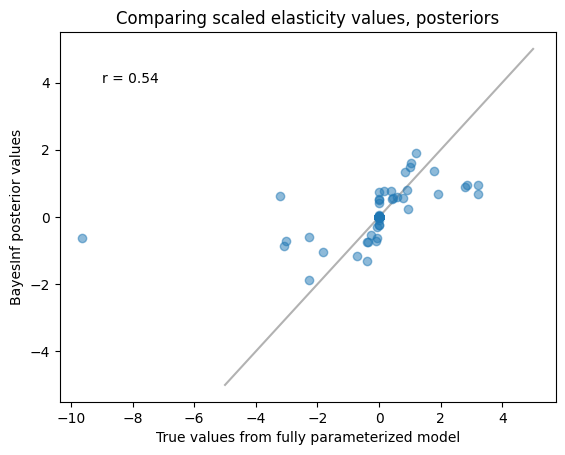

In [23]:
plt.scatter(Ex_values, x, alpha=0.5)
plt.plot([-5,5], [-5,5], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled elasticity values, posteriors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf posterior values')

plt.text(-9,4,'r = ' + str((stats.pearsonr(Ex_values.flatten(), x.flatten())[0]).round(3)))

# the dot all the way to the left is P on PGK

## Plotting MCC and FCC comparisons

In [24]:
gtCCC = pd.DataFrame(r.getScaledConcentrationControlCoefficientMatrix(), index=r.getFloatingSpeciesIds(), columns=r.getReactionIds())
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

In [25]:
visCCC, visFCC = util.elasticity_to_CCC(BIOMD64, BIOMD64.Ex)  
visCCC = pd.DataFrame(visCCC, index=r.getFloatingSpeciesIds(), columns=r.getReactionIds())
visFCC.columns = r.getReactionIds()
visFCC.index = r.getReactionIds()
visFCC

,vGLK,vPGI,vGLYCO,vTreha,vPFK,vALD,vGAPDH,vPGK,vPGM,vENO,vPYK,vPDC,vSUC,vGLT,vADH,vG3PDH,vATP
vGLK,0.139587,0.079511,0.031414,0.028661,0.079511,0.079511,0.077840,0.077840,0.077840,0.077840,0.077840,0.077840,0.000836,0.139587,0.077004,0.001671,-0.124330
vPGI,0.082789,0.110380,-0.015836,-0.011755,0.110380,0.110380,0.075443,0.075443,0.075443,0.075443,0.075443,0.075443,0.017469,0.082789,0.057974,0.034937,-0.032161
vGLYCO,0.546373,-0.141574,0.814264,-0.126317,-0.141574,-0.141574,0.095007,0.095007,0.095007,0.095007,0.095007,0.095007,-0.118290,0.546373,0.213298,-0.236581,-0.784441
vTreha,0.546373,-0.141574,-0.185736,0.873683,-0.141574,-0.141574,0.095007,0.095007,0.095007,0.095007,0.095007,0.095007,-0.118290,0.546373,0.213298,-0.236581,-0.784441
vPFK,0.082789,0.110380,-0.015836,-0.011755,0.110380,0.110380,0.075443,0.075443,0.075443,0.075443,0.075443,0.075443,0.017469,0.082789,0.057974,0.034937,-0.032161
vALD,0.082789,0.110380,-0.015836,-0.011755,0.110380,0.110380,0.075443,0.075443,0.075443,0.075443,0.075443,0.075443,0.017469,0.082789,0.057974,0.034937,-0.032161
vGAPDH,0.068474,0.075238,-0.003063,-0.003702,0.075238,0.075238,0.087462,0.087462,0.087462,0.087462,0.087462,0.087462,-0.006112,0.068474,0.093574,-0.012224,0.044089
vPGK,0.068474,0.075238,-0.003063,-0.003702,0.075238,0.075238,0.087462,0.087462,0.087462,0.087462,0.087462,0.087462,-0.006112,0.068474,0.093574,-0.012224,0.044089
vPGM,0.068474,0.075238,-0.003063,-0.003702,0.075238,0.075238,0.087462,0.087462,0.087462,0.087462,0.087462,0.087462,-0.006112,0.068474,0.093574,-0.012224,0.044089
vENO,0.068474,0.075238,-0.003063,-0.003702,0.075238,0.075238,0.087462,0.087462,0.087462,0.087462,0.087462,0.087462,-0.006112,0.068474,0.093574,-0.012224,0.044089


In [26]:
postCCC, postFCC = util.elasticity_to_CCC(BIOMD64, Ex)  
postCCC = pd.DataFrame(postCCC, index=r.getFloatingSpeciesIds(), columns=r.getReactionIds())
postFCC = pd.DataFrame(postFCC) #, index=r.getReactionIds(), columns=r.getReactionIds())
postFCC.columns = r.getReactionIds()
postFCC.index = r.getReactionIds()
postFCC

,vGLK,vPGI,vGLYCO,vTreha,vPFK,vALD,vGAPDH,vPGK,vPGM,vENO,vPYK,vPDC,vSUC,vGLT,vADH,vG3PDH,vATP
vGLK,0.107503,0.012243,0.035755,0.031039,0.061475,0.118058,0.085900,0.056642,0.121784,0.057074,0.073210,0.073303,-0.022692,0.188313,0.044091,0.042072,-0.085772
vPGI,0.109109,0.014382,-0.027466,-0.020565,0.072212,0.138969,0.090463,0.059650,0.128253,0.060040,0.077016,0.077115,-0.017522,0.191009,0.036416,0.060495,-0.049576
vGLYCO,0.051090,-0.000877,0.942798,-0.036224,-0.004405,-0.010393,0.063304,0.041742,0.089748,0.041613,0.053378,0.053455,-0.059667,0.088695,0.099210,-0.077534,-0.335931
vTreha,0.152144,-0.005815,-0.079277,0.946695,-0.029199,-0.058338,0.040616,0.026782,0.057583,0.028599,0.036684,0.036698,-0.059789,0.269384,0.098874,-0.105292,-0.356346
vPFK,0.109109,0.014382,-0.027466,-0.020565,0.072212,0.138969,0.090463,0.059650,0.128253,0.060040,0.077016,0.077115,-0.017522,0.191009,0.036416,0.060495,-0.049576
vALD,0.109109,0.014382,-0.027466,-0.020565,0.072212,0.138969,0.090463,0.059650,0.128253,0.060040,0.077016,0.077115,-0.017522,0.191009,0.036416,0.060495,-0.049576
vGAPDH,0.087229,0.011120,-0.016102,-0.012912,0.055835,0.106370,0.105143,0.069330,0.149065,0.069153,0.088705,0.088832,-0.048315,0.151540,0.085458,0.008493,0.001056
vPGK,0.087229,0.011120,-0.016102,-0.012912,0.055835,0.106370,0.105143,0.069330,0.149065,0.069153,0.088705,0.088832,-0.048315,0.151540,0.085458,0.008493,0.001056
vPGM,0.087229,0.011120,-0.016102,-0.012912,0.055835,0.106370,0.105143,0.069330,0.149065,0.069153,0.088705,0.088832,-0.048315,0.151540,0.085458,0.008493,0.001056
vENO,0.087229,0.011120,-0.016102,-0.012912,0.055835,0.106370,0.105143,0.069330,0.149065,0.069153,0.088705,0.088832,-0.048315,0.151540,0.085458,0.008493,0.001056


Text(-4, 4, 'r = 0.482')

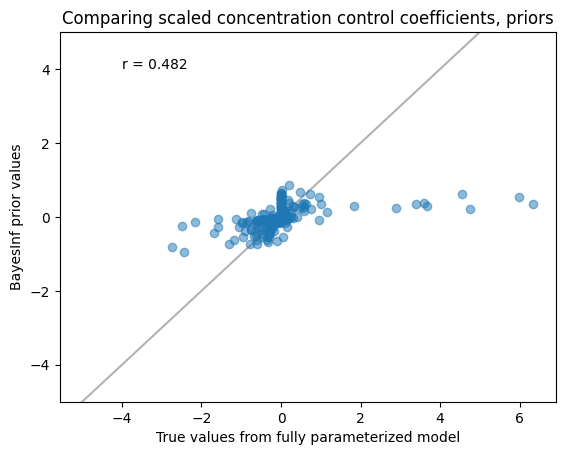

In [27]:
fig = plt.figure()

plt.scatter(gtCCC, visCCC, alpha=0.5)
plt.plot([-5,5], [-5,5], 'k-', alpha=0.3, zorder=0)
plt.ylim([-5,5])
plt.title('Comparing scaled concentration control coefficients, priors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf prior values')

plt.text(-4,4,'r = ' + str((stats.pearsonr(gtCCC.to_numpy().flatten(), visCCC.to_numpy().flatten())[0]).round(3)))


Text(-4, 4, 'r = 0.67')

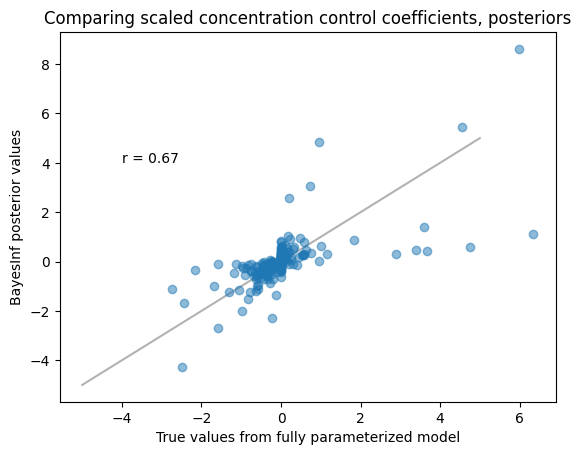

In [28]:
fig = plt.figure()

plt.scatter(gtCCC, postCCC, alpha=0.5)
plt.plot([-5,5], [-5,5], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled concentration control coefficients, posteriors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf posterior values')

plt.text(-4,4,'r = ' + str((stats.pearsonr(gtCCC.to_numpy().flatten(), postCCC.to_numpy().flatten())[0]).round(3)))

Text(-1, 2, 'r = 0.234')

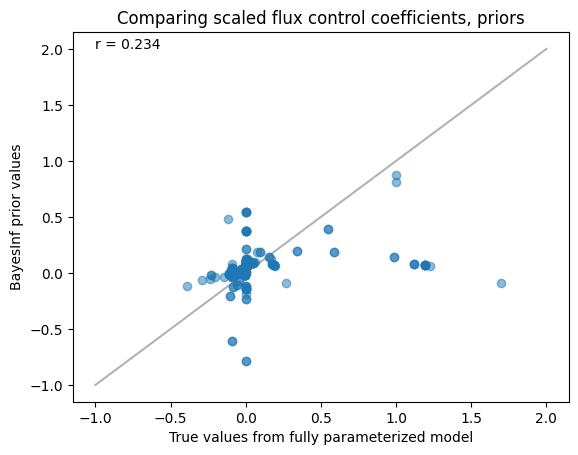

In [29]:
fig = plt.figure()

plt.scatter(gtFCC, visFCC, alpha=0.5)
plt.plot([-1,2], [-1,2], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled flux control coefficients, priors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf prior values')
plt.text(-1,2,'r = ' + str((stats.pearsonr(gtFCC.to_numpy().flatten(), visFCC.to_numpy().flatten())[0]).round(3)))

Text(-1, 2, 'r = 0.479')

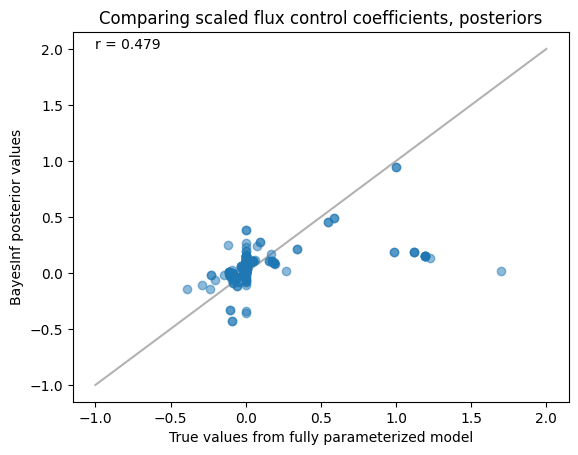

In [30]:
fig = plt.figure()

plt.scatter(gtFCC, postFCC, alpha=0.5)
plt.plot([-1,2], [-1,2], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled flux control coefficients, posteriors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf posterior values')

plt.text(-1,2,'r = ' + str((stats.pearsonr(gtFCC.to_numpy().flatten(), postFCC.to_numpy().flatten())[0]).round(3)))

## Pairwise comparison of FCC values

In [31]:
def plot_pairwise_FCCs(yield_enzyme):
    priors = pd.DataFrame(visFCC[yield_enzyme])
    priors['distribution'] = ['prior']* len(priors)
    posteriors = pd.DataFrame(postFCC[yield_enzyme])
    posteriors['distribution'] = ['posterior']* len(posteriors)
    paired = pd.concat([priors, posteriors]).reset_index()
    pv_tbl = paired.pivot('index', 'distribution', yield_enzyme)

    fig = pv_tbl[['prior', 'posterior']].plot(kind='bar', colormap='winter')
    plt.title(f'FCCs for {yield_enzyme}, before & after Bayesian inference')

    for i,val in enumerate(gtFCC[yield_enzyme]):
        plt.axhline(y = val,    # Line on y = 0.2
                xmin = (i+0.2)/len(gtFCC[yield_enzyme]), # From the left
                xmax = (i+0.8)/len(gtFCC[yield_enzyme]), 
                c='red') # To the right

C:\Users\user\AppData\Local\Temp\ipykernel_15988\1095821133.py:7: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.

C:\Users\user\AppData\Local\Temp\ipykernel_15988\1095821133.py:7: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.

C:\Users\user\AppData\Local\Temp\ipykernel_15988\1095821133.py:7: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.

C:\Users\user\AppData\Local\Temp\ipykernel_15988\1095821133.py:7: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.

C:\Users\user\AppData\Local\Temp\ipykernel_15988\1095821133.py:7: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.

C:\Users\user\AppData\Local\Temp\ipykernel_15988\1095821133.py:7: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword

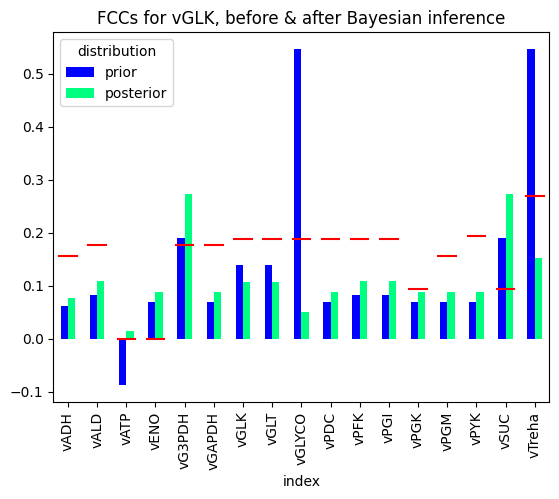

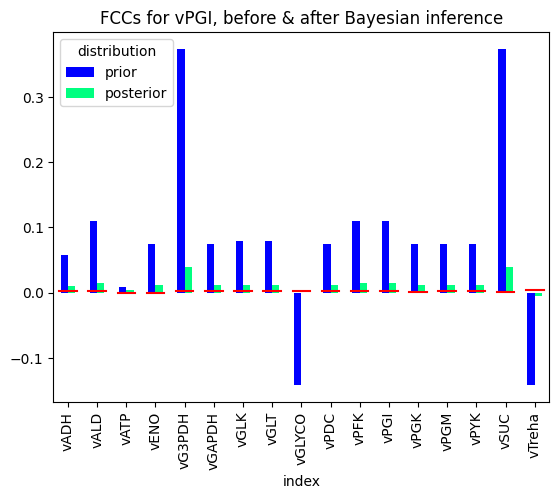

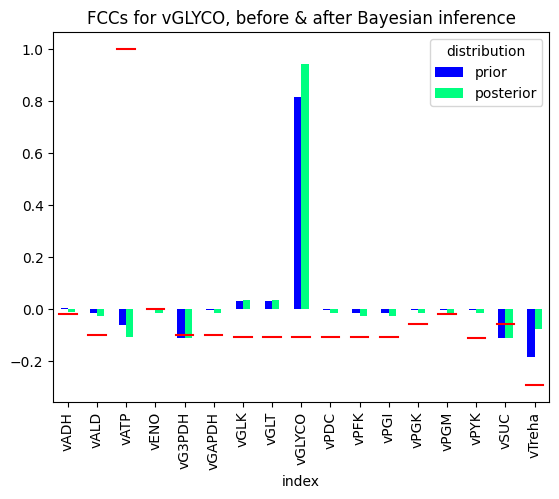

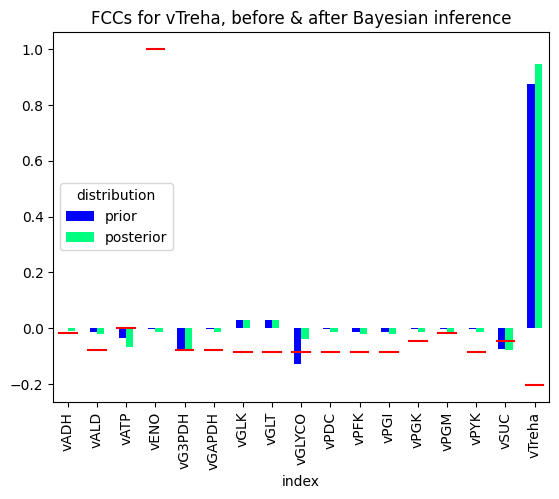

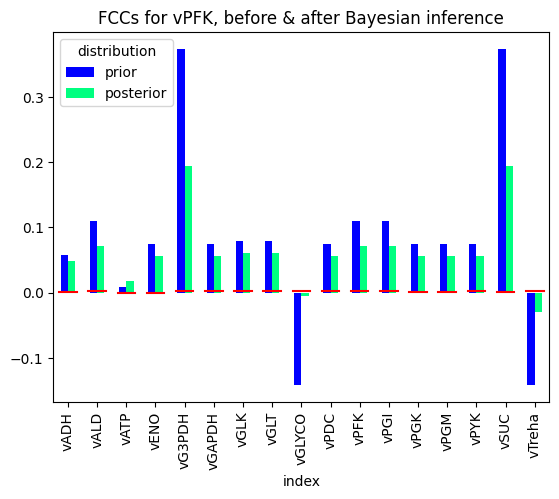

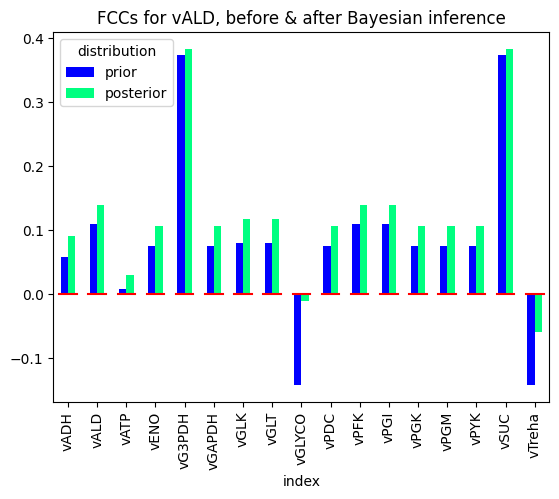

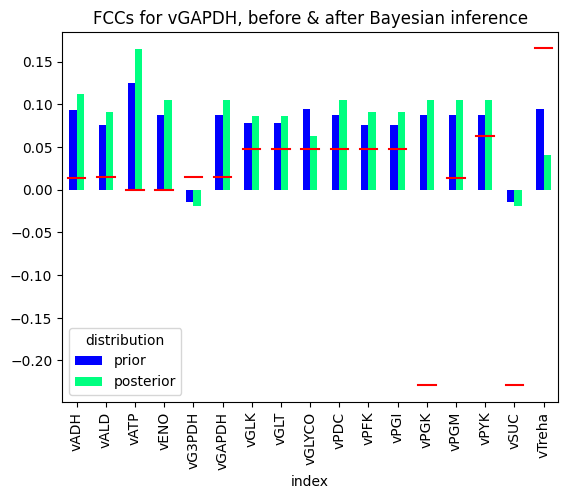

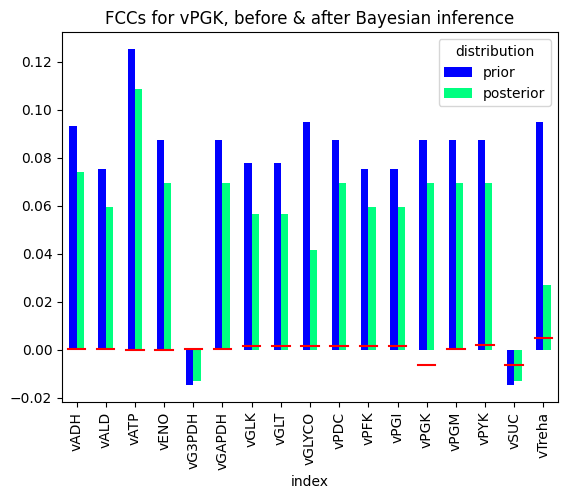

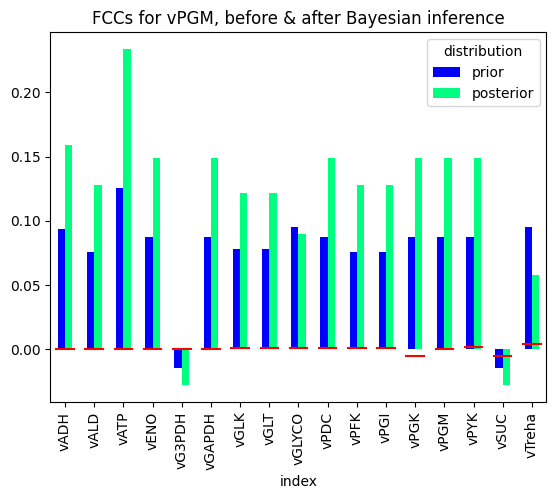

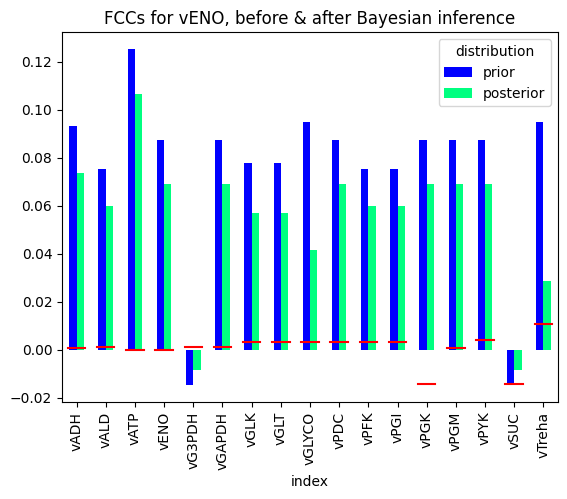

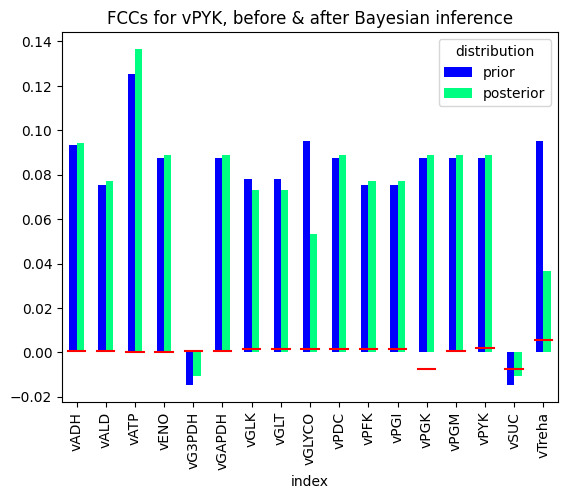

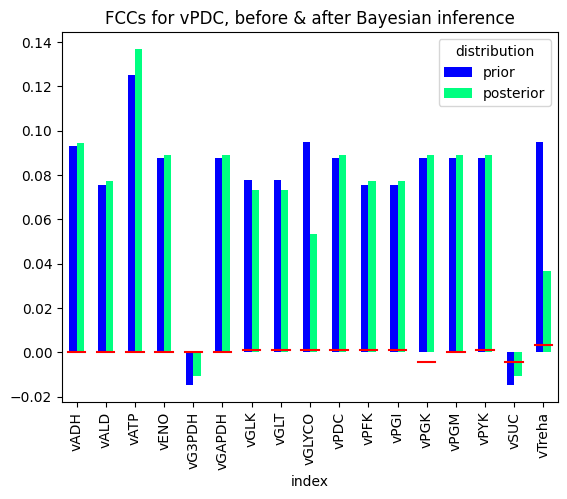

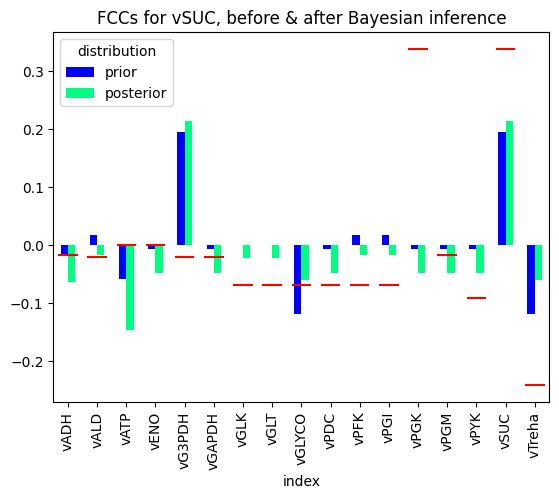

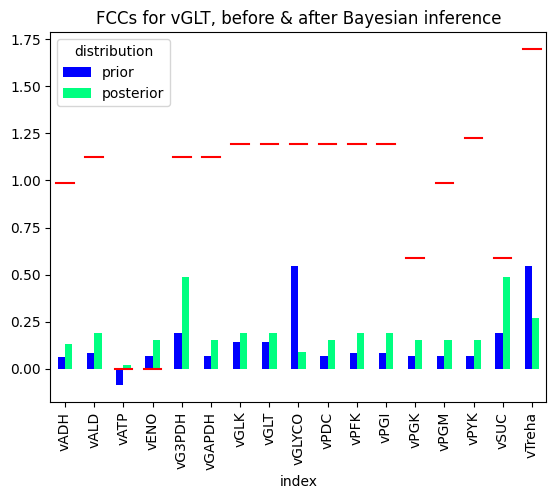

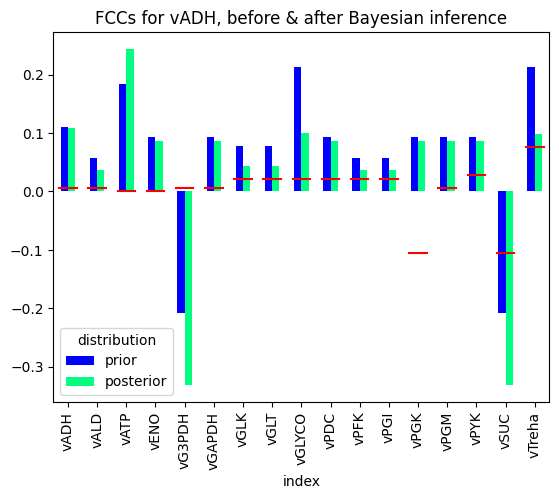

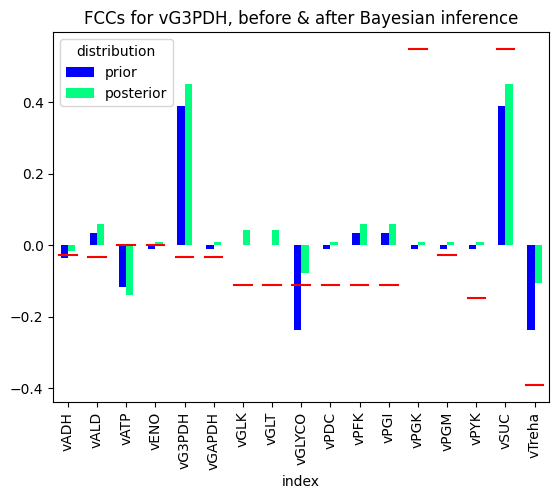

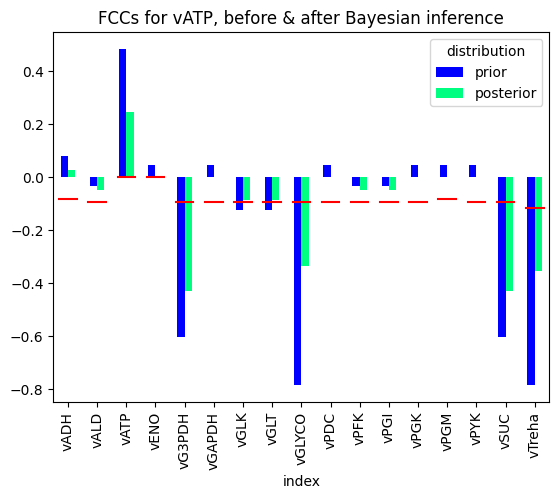

In [34]:
for i,rxn in enumerate(r.getReactionIds()):
    plot_pairwise_FCCs(rxn)

## Ranking FCC values

In [35]:
def rank_FCC_values(yield_enzyme): 
    FCCrankings = pd.concat([gtFCC.loc[yield_enzyme].rank(), visFCC.loc[yield_enzyme].rank(), postFCC.loc[yield_enzyme].rank()], axis=1)
    FCCrankings.columns=['gt', 'visE', 'postE']

    fig = plt.figure()

    plt.scatter(FCCrankings['gt'], FCCrankings['visE'], alpha=0.5, label='visE')
    plt.scatter(FCCrankings['gt'], FCCrankings['postE'], alpha=0.5, label='postE')
    plt.plot([0,20], [0,20], 'k-', alpha=0.3, zorder=0)
    plt.title(f'Comparing scaled flux control coefficient rankings, {yield_enzyme}')
    plt.xlabel('ordinal values from fully parameterized model')
    plt.ylabel('ordinal values from linlog approximations')

    plt.text(13,2,'visE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['visE'])[0]).round(3)))
    plt.text(13,1,'postE_Sp = ' + str((stats.pearsonr(FCCrankings['gt'], FCCrankings['postE'])[0]).round(3)))
    plt.text(13,0,'Wilcoxon p-value = ' + str((stats.wilcoxon(FCCrankings['visE'], FCCrankings['postE'])[1]).round(3)))
    plt.legend()

    FCCrankings['visE_dif'] = FCCrankings['visE'] - FCCrankings['gt']
    FCCrankings['postE_dif'] = FCCrankings['postE'] - FCCrankings['gt']
    FCCrankings.sort_values('gt')[['visE_dif','postE_dif']].plot(kind='bar', align='edge', width=0.7, alpha=0.7)
    plt.title(f'Rankings of FCC values for {yield_enzyme} predicted by Bayesian inference')
    plt.xlabel("reactions in order of gt FCC ranking")
    plt.ylabel("FCC ranking")

    return FCCrankings.sort_values('gt')

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning:

Exact p-value calculation does not work if there are zeros. Switching to normal approximation.



,gt,visE,postE,visE_dif,postE_dif
vG3PDH,1.0,1.0,2.0,0.0,1.0
vGLYCO,2.0,4.0,3.0,2.0,1.0
vATP,3.0,10.0,6.0,7.0,3.0
vSUC,4.0,2.0,1.0,-2.0,-3.0
vTreha,5.0,3.0,4.0,-2.0,-1.0
vALD,6.0,5.0,11.0,-1.0,5.0
vPDC,7.0,16.0,13.0,9.0,6.0
vPGM,8.0,13.5,17.0,5.5,9.0
vPGK,9.0,13.5,9.0,4.5,0.0
vPYK,10.0,12.0,12.0,2.0,2.0


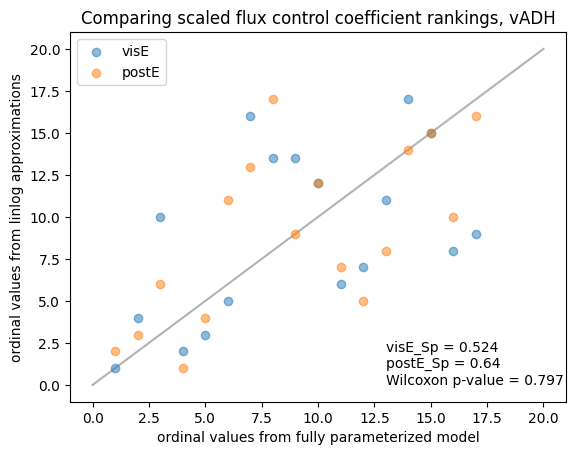

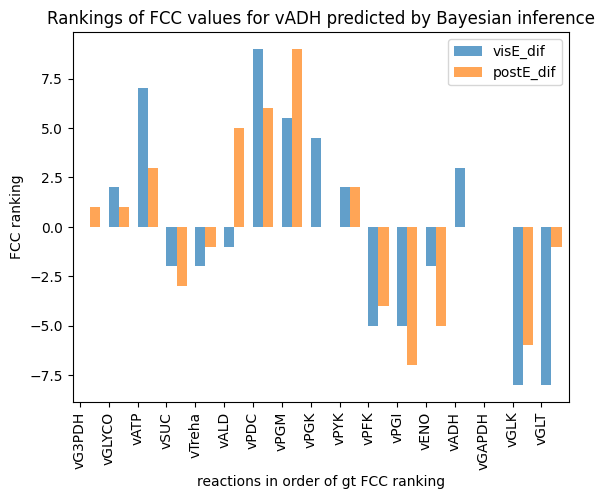

In [36]:
rank_FCC_values('vADH')

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning:

Exact p-value calculation does not work if there are zeros. Switching to normal approximation.



,gt,visE,postE,visE_dif,postE_dif
vGLYCO,1.0,2.0,2.0,1.0,1.0
vATP,2.0,1.0,1.0,-1.0,-1.0
vTreha,3.0,3.0,3.0,0.0,0.0
vG3PDH,4.0,5.0,9.0,1.0,5.0
vSUC,5.0,4.0,4.0,-1.0,-1.0
vPDC,6.0,8.0,12.0,2.0,6.0
vPGM,7.0,12.0,15.0,5.0,8.0
vALD,8.0,17.0,16.0,9.0,8.0
vPGK,9.0,10.0,7.0,1.0,-2.0
vPYK,10.0,11.0,11.0,1.0,1.0


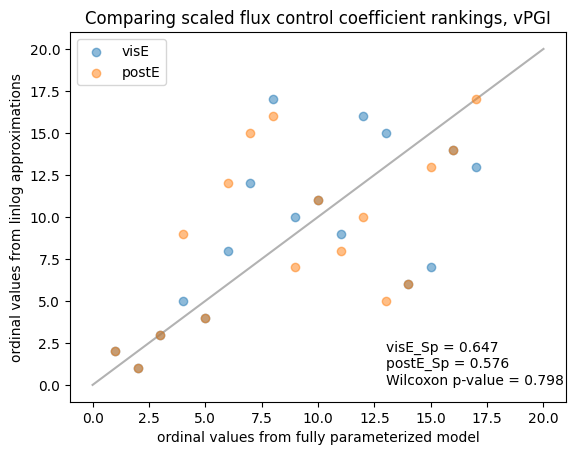

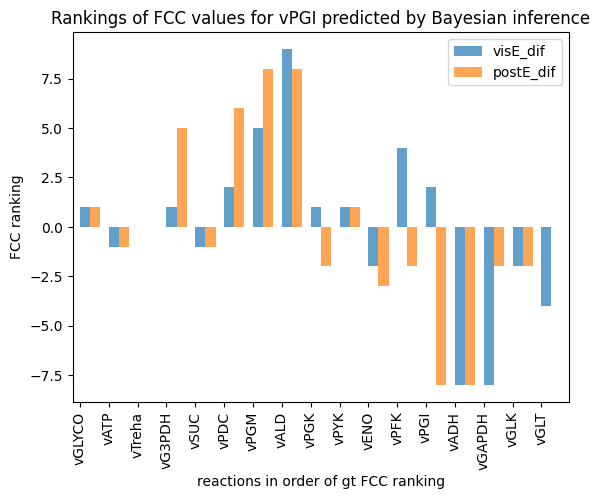

In [37]:
rank_FCC_values('vPGI')

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\scipy\stats\_morestats.py:3337: UserWarning:

Exact p-value calculation does not work if there are zeros. Switching to normal approximation.



,gt,visE,postE,visE_dif,postE_dif
vG3PDH,1.0,1.0,5.0,0.0,4.0
vGLYCO,2.0,4.0,2.0,2.0,0.0
vATP,3.0,5.0,4.0,2.0,1.0
vTreha,4.0,3.0,3.0,-1.0,-1.0
vSUC,5.0,2.0,1.0,-3.0,-4.0
vALD,6.0,9.0,15.0,3.0,9.0
vPDC,7.0,13.0,13.0,6.0,6.0
vPGM,8.0,15.0,16.0,7.0,8.0
vPGK,9.0,12.0,9.0,3.0,0.0
vPYK,10.0,14.0,12.0,4.0,2.0


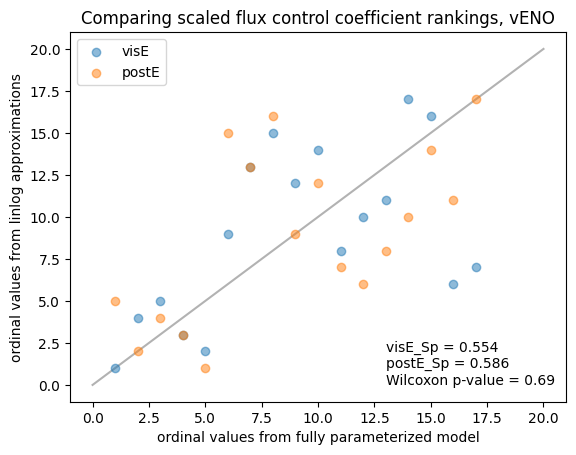

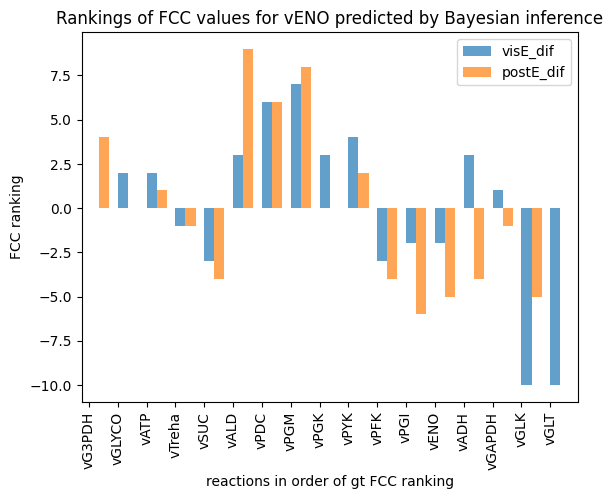

In [38]:
rank_FCC_values('vENO')

## Distribution of FCC 

In [39]:
visE_r=[]
postE_r=[]

for i in r.getReactionIds():        
    FCCrankings = pd.concat([gtFCC.loc[i].rank(), visFCC.loc[i].rank(), postFCC.loc[i].rank()], axis=1)
    FCCrankings.columns=['gt', 'visE', 'postE']

    visE_r.append(stats.pearsonr(FCCrankings['gt'], FCCrankings['visE'])[0])
    postE_r.append(stats.pearsonr(FCCrankings['gt'], FCCrankings['postE'])[0])


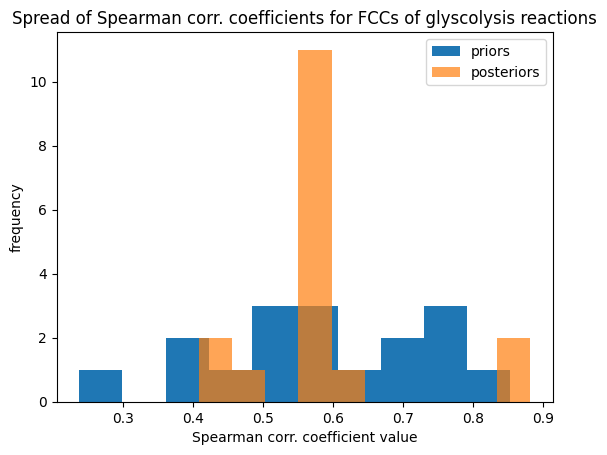

In [40]:
plt.hist(visE_r, label='priors')
plt.hist(postE_r, alpha=0.7, label='posteriors')
plt.legend()
plt.xlabel('Spearman corr. coefficient value')
plt.ylabel('frequency')
plt.title('Spread of Spearman corr. coefficients for FCCs of glyscolysis reactions')

plt.show()
